<a href="https://colab.research.google.com/github/sena1bayram/BrainCancer/blob/main/braincancer2_deneme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
orvile_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/brain-cancer-mri-dataset')

print('Data source import complete.')


Data source import complete.


Veri başarıyla bölündü.
Found 4237 images belonging to 3 classes.
Found 909 images belonging to 3 classes.
Found 910 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 940s 7s/step - accuracy: 0.6643 - loss: 0.7559 - val_accuracy: 0.4675 - val_loss: 1.4483 - learning_rate: 5.0000e-04
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 937s 7s/step - accuracy: 0.8014 - loss: 0.4895 - val_accuracy: 0.3377 - val_loss: 4.6144 - learning_rate: 5.0000e-04
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 935s 7s/step - accuracy: 0.8484 - loss: 0.3991 - val_accuracy: 0.3377 - val_loss: 5.6916 - learning_rate: 5.0000e-04
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 929s 7s/step - accuracy: 0.8763 - loss: 0.3399 - val_accuracy: 0.3377 - val_loss: 5.1724 - learning_rate: 5.0000e-04
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8863 - loss: 0.3097
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
133/133 ━━━━━━━━━━━━━━━━━━━━ 930s 7s/step - accuracy: 0.8862 - loss: 0.3097 - val_accuracy: 0.4004 - val_loss: 2.1044 - learning_rate: 5.0000e-04
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 927s 7s/step - accuracy: 

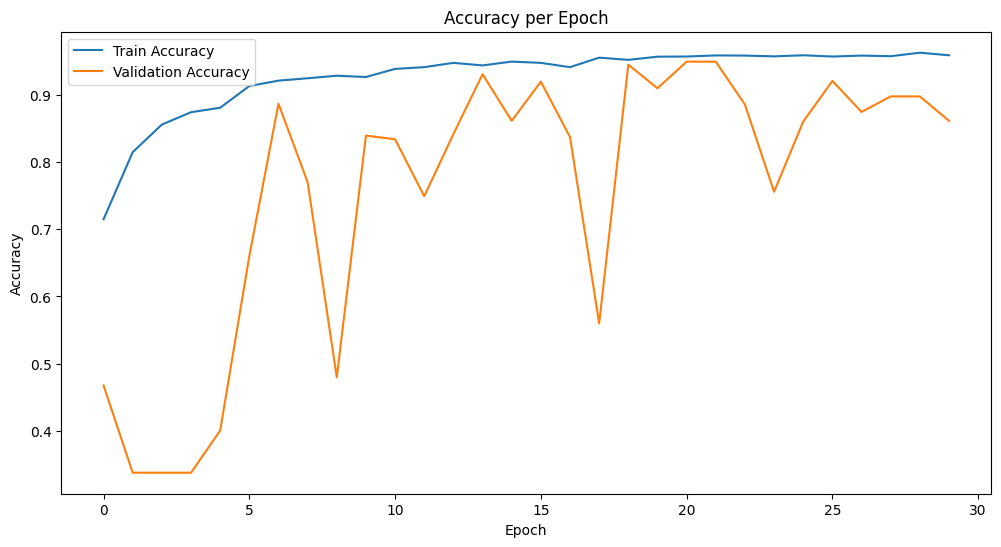

29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


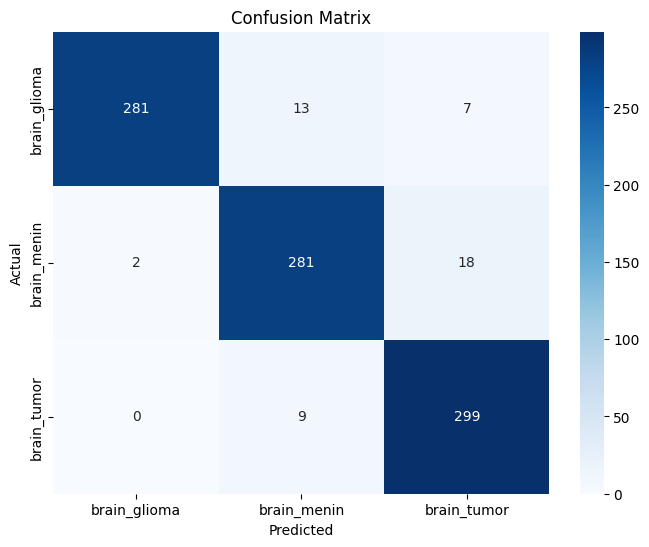

              precision    recall  f1-score   support

brain_glioma       0.99      0.93      0.96       301
 brain_menin       0.93      0.93      0.93       301
 brain_tumor       0.92      0.97      0.95       308

    accuracy                           0.95       910
   macro avg       0.95      0.95      0.95       910
weighted avg       0.95      0.95      0.95       910

Model kaydedildi: brain_cancer_best_cnn_model.h5


In [ ]:
# 📦 Gerekli Kütüphaneler
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📂 1. Veri Bölme (Train/Val/Test)
original_data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'
base_dir = '/kaggle/working/brain_cancer_split'

classes = ['brain_glioma', 'brain_menin', 'brain_tumor']

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

for cls in classes:
    cls_path = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    for idx, img in enumerate(images):
        if idx < train_split:
            split = 'train'
        elif idx < val_split:
            split = 'val'
        else:
            split = 'test'

        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, split, cls, img)
        shutil.copyfile(src, dst)

print("Veri başarıyla bölündü.")

# 📈 2. Data Generators
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 🧠 3. CNN Modeli - İyileştirilmiş
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ⏳ 4. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-6)

# 🚀 5. Model Eğitimi
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# 🎯 6. Test Sonucu
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Set Accuracy: {test_acc:.2%}")

# 📊 7. Eğitim/Doğrulama Grafikleri
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 🔥 8. Confusion Matrix ve Classification Report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 💾 9. Modeli Kaydet
model.save('/kaggle/working/brain_cancer_best_cnn_model.h5')
print("Model kaydedildi: brain_cancer_best_cnn_model.h5")
